## Notebook to study effect of mouse age on cell type clusters

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import pickle
import json

In [2]:
def evalPanel(geneData,genePanel,cluster, showPlot = True):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Plot confusion matrix if requested
    if showPlot:
        plt.figure(figsize=(48, 32), dpi=80)
        confMatrix = confusion_matrix(cluster.to_numpy(),assignedCluster)
        ax = sns.heatmap(confMatrix) # cmap = "viridis")
        
        # Format heatmap
        nClusters = len(pd.unique(cluster))
        plt.xticks(np.linspace(0.5,nClusters - .5,nClusters), pd.unique(cluster), fontsize = 8)
        plt.yticks(np.linspace(0.5,nClusters - .5,nClusters), pd.unique(cluster), fontsize = 8)
        plt.title("Classification Accuracy: %1.1f%%" %round(accuracy*100,2),fontsize=36)
        plt.xlabel("Original Label", fontsize = 24)
        plt.ylabel("Assigned Label", fontsize = 24)
        return accuracy, ax, confMatrix
    else:
        return accuracy

In [3]:
# Load in pre-processed data from glutamatergic class designation
devData = sc.read("../Data/devData.h5ad")

# Load most up to date cluster codes
clCodes = pd.read_feather("../Data/cluster_results.feather")
clCodes = clCodes.rename(columns={'id': 'sample_id', 'clusterData.cl.result.cl': 'cl'})
clCodes.set_index('sample_id',inplace=True)

# Combine cluster code w/ AnnData object
devData.obs = devData.obs.merge(clCodes,how='inner',left_index=True,right_index=True,validate = "1:1")

# Index by cell class
gluData = devData[devData.obs.class_label == "Glutamatergic"]

    
with open("../Results/Gene Panels/PROPOSE_p11_p14_panel.json", "r") as f:
    prPanel = json.load(f)

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Age-specific clusters

In [106]:
ageClusters = {}
ageCount = np.zeros(len(devData.obs["age"].unique()) + 1)

indx = 0
for age in devData.obs["age"].unique():
    ageData = devData[devData.obs["age"] == age]
    ageCount[indx] = len(ageData.obs["cl"].unique())
    ageClusters[age] = ageData.obs["cl"].unique()
    indx = indx + 1


ageCount[-1] = 264 # Manually add in adult data

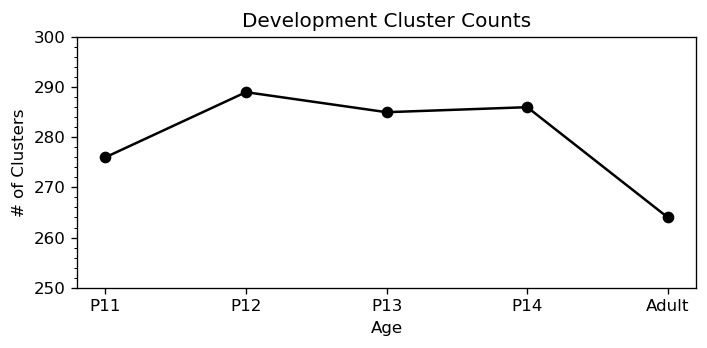

In [118]:
plotAges = devData.obs["age"].unique().add_categories(["Adult"])

plt.figure(figsize=(6, 3), dpi=120)
plt.plot(plotAges.categories,ageCount,'ok-')
plt.ylim([250, 300])
# plt.yticks([250,270,290])
plt.minorticks_on()
plt.tick_params(which='minor',bottom=False)
plt.ylabel('# of Clusters')
plt.xlabel('Age')
plt.title('Development Cluster Counts')
plt.tight_layout()
plt.savefig('../Results/Dev Cluster Counts.png')

In [43]:
set(ageClusters["P12"]) - set(ageClusters["P11"])

{12,
 25,
 42,
 47,
 50,
 62,
 70,
 83,
 93,
 107,
 149,
 157,
 192,
 194,
 196,
 201,
 277,
 314,
 315,
 318,
 319,
 322,
 326,
 329,
 346,
 349,
 361,
 383,
 386,
 389,
 390,
 392,
 393,
 394,
 431}

In [44]:
# Create array of cluster sizes by age
typeCount = np.zeros((len(gluData.obs["cl"].unique()), len(gluData.obs["age"].unique())),'int')

# Dispense the number of cells within each cluster
gluTypes = gluData.obs["cl"].unique()
ageTypes = gluData.obs["age"].unique()
a = 0
for age in ageTypes:
    sampleData = gluData[gluData.obs["age"] == age]
    typeCount[:,a] = [sum(sampleData.obs["cl"] == name) for name in gluTypes]
    a = a + 1

# Convert to dataframe
ageClCounts= pd.DataFrame(typeCount, index = gluTypes, columns = ageTypes)

In [100]:
(len(gluData[gluData.obs["age"] == 'P12']) - 146) / 224

93.84375

In [90]:
len(gluData[gluData.obs["age"] == 'P12'])

21167

In [60]:
ageClCounts.loc[set(ageClusters["P12"]) - set(ageClusters["P11"])].sum(axis = 0)

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_3984\2897561432.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ageClCounts.loc[set(ageClusters["P12"]) - set(ageClusters["P11"])].sum(axis = 0)


P11      0
P12    146
P13    513
P14     97
dtype: int64

In [14]:
p11Data = devData[devData.obs["age"] == "P13"]

In [15]:
len(np.unique(p11Data.obs["cl"]))

285

## Age specific cluster size

In [132]:
# Create array of cluster sizes by age
typeCount = np.zeros((len(gluData.obs["cluster_label"].unique()), len(gluData.obs["age"].unique())),'int')

# Dispense the number of cells within each subclass
gluTypes = gluData.obs["cluster_label"].unique()
ageTypes = gluData.obs["age"].unique()
a = 0
for age in ageTypes:
    sampleData = gluData[gluData.obs["age"] == age]
    typeCount[:,a] = [sum(sampleData.obs["cluster_label"] == name) for name in gluTypes]
    a = a + 1

# Convert to dataframe
ageCounts = pd.DataFrame(typeCount, index = gluTypes, columns = ageTypes)

<AxesSubplot:>

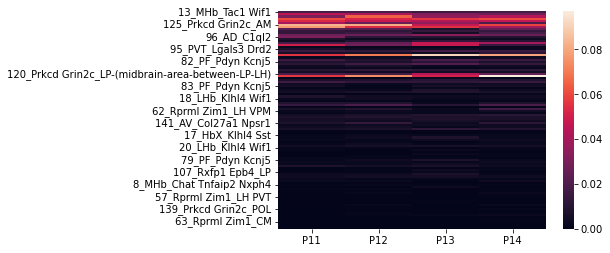

In [137]:
sns.heatmap(ageCounts / np.sum(ageCounts))

## Look at how UMAPs vary with age

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


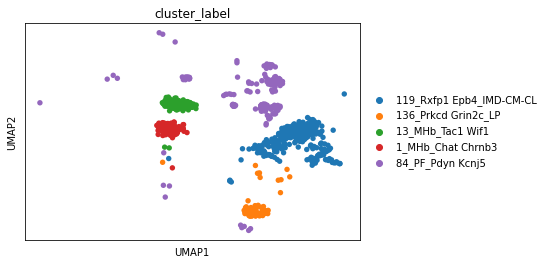

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


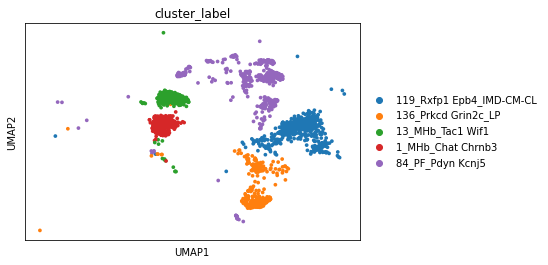

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


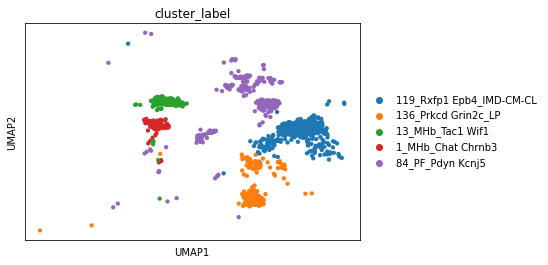

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


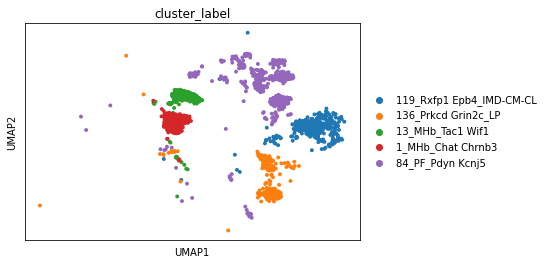

In [121]:
# Plot umap as function of age
gluTypes = gluData.obs["cluster_label"].unique()
for age in gluData.obs["age"].unique():
    sampleData = gluData[(gluData.obs["age"] == age) & gluData.obs["cluster_label"].isin(gluTypes[[0, 5, 10, 15, 25]])]
    # Further reduce to examine only a few clusters
    sc.pl.umap(sampleData, color="cluster_label")

## Look at classification accuracy as function of age

In [25]:
# Load panels designed for specific panels
with open("../Results/Gene Panels/P14_PROPOSE_cluster_markers.json", "r") as f:
    p14Panel = json.load(f)

with open("../Results/Gene Panels/P12_PROPOSE_cluster_markers.json", "r") as f:
    p12Panel = json.load(f)

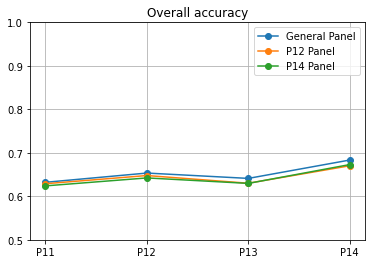

In [43]:
# Create array of cluster sizes by age
allAcc = np.zeros(len(gluData.obs["age"].unique()))
p12Acc = np.zeros(len(gluData.obs["age"].unique()))
p14Acc = np.zeros(len(gluData.obs["age"].unique()))

# Dispense the accuracy at each age
ageTypes = gluData.obs["age"].unique()
a = 0
for age in ageTypes:
    sampleData = gluData[gluData.obs["age"] == age]
    allAcc[a] = evalPanel(sampleData,prPanel['347'],sampleData.obs["cluster_label"],False)
    p12Acc[a] = evalPanel(sampleData,p12Panel['350'],sampleData.obs["cluster_label"],False)
    p14Acc[a] = evalPanel(sampleData,p14Panel['350'],sampleData.obs["cluster_label"],False)
        #sum(sampleData.obs["subclass_label"] == name) for name in gluTypes]
    a = a + 1

# Plot accuracy
plt.plot(ageTypes,allAcc,'o-',label = 'General Panel')
plt.plot(ageTypes,p12Acc,'o-',label = 'P12 Panel')
plt.plot(ageTypes,p14Acc,'o-',label = 'P14 Panel')
plt.ylim([.5, 1])
plt.title('Overall accuracy')
plt.grid()
plt.legend()

In [36]:
len(set(p14Panel['350']) - set(p12Panel['350']))

246

## Subclass UMAPs

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


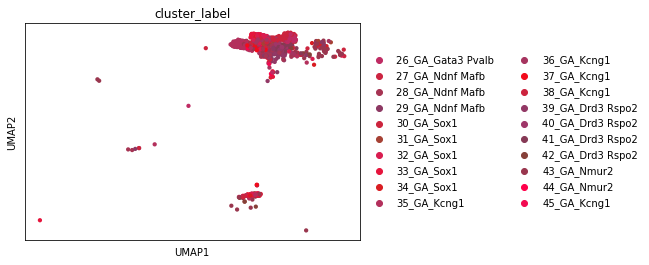

In [167]:
# Plot cluster umap, using cluster colors
subTypes = devData.obs["subclass_label"].unique()
sampleData = devData[devData.obs["subclass_label"] == (subTypes[15])]
color_dict = dict(zip(sampleData.obs["cluster_label"],sampleData.obs["cluster_color"]))
# plt.figure(figsize=(40, 40), dpi=150)
sc.pl.umap(sampleData, color="cluster_label",palette =color_dict)
# sc.pl.umap(devData, color="cluster_label")

In [ ]:
# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

## Dendrogram

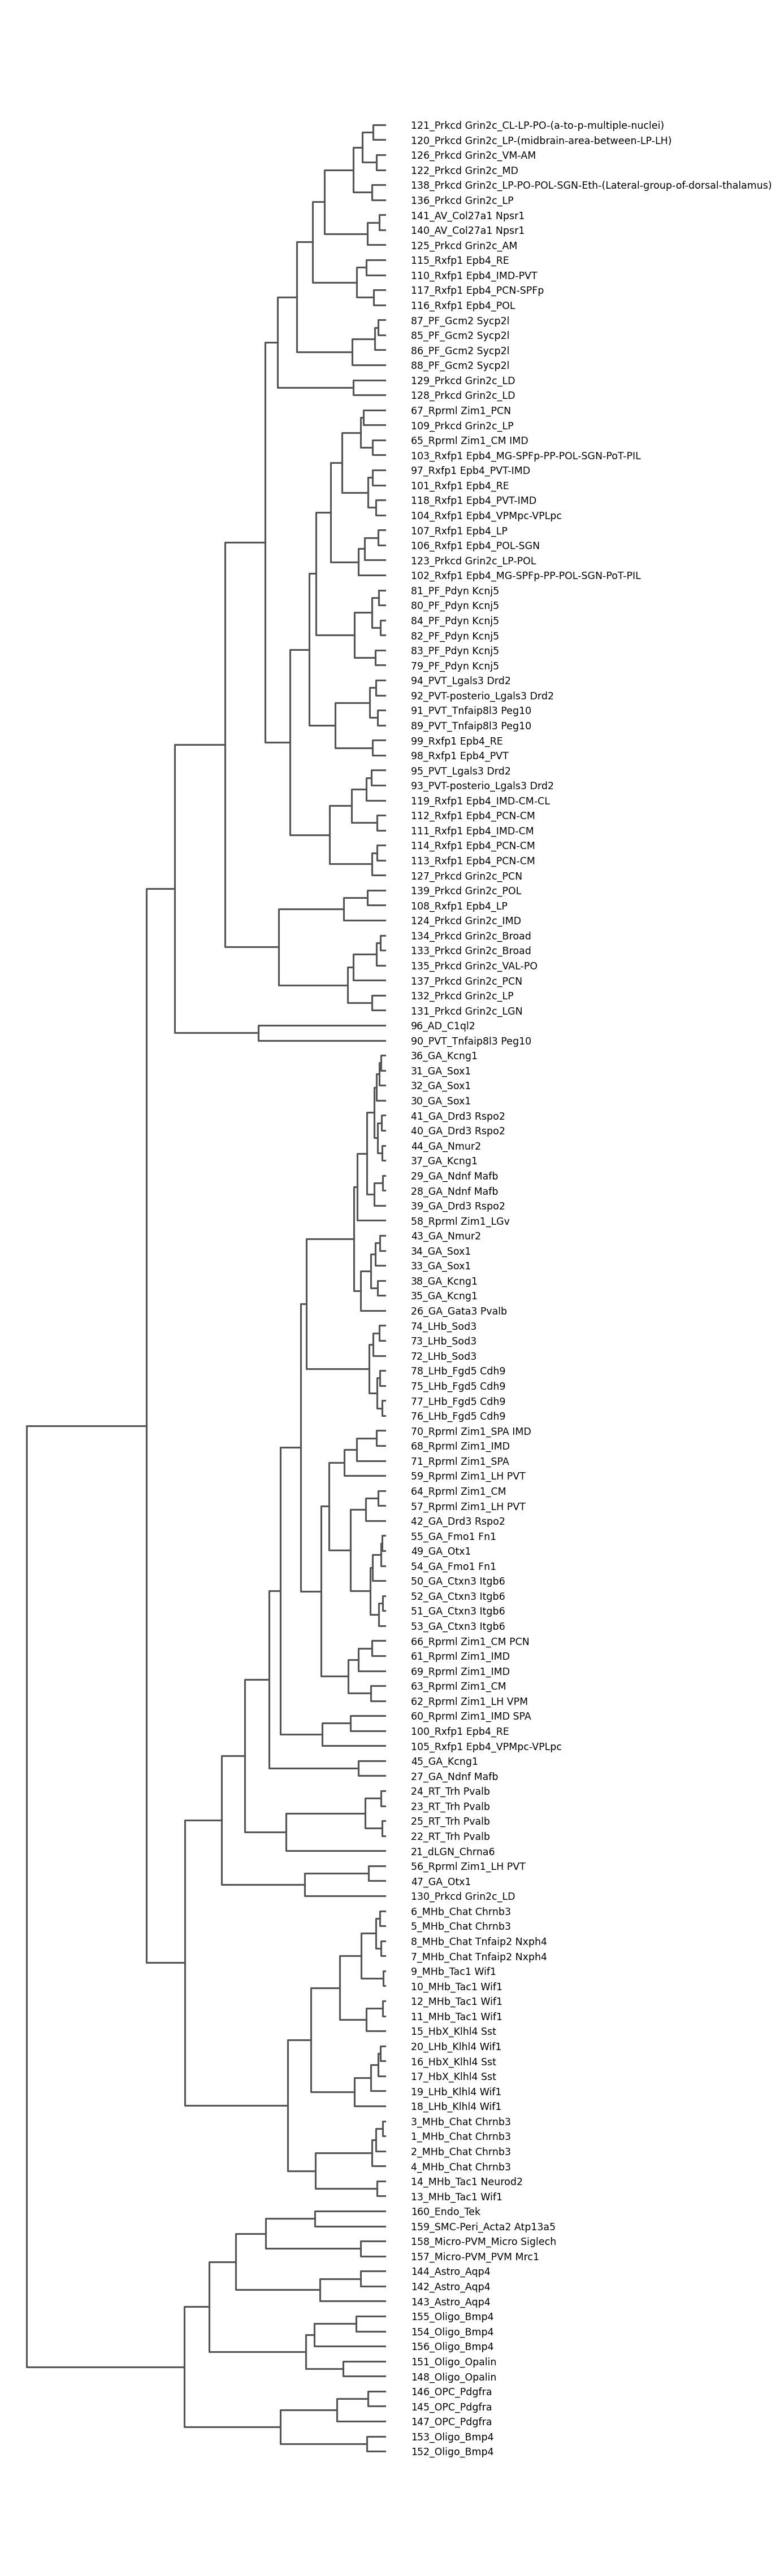

<AxesSubplot:>

In [120]:
# Plot dendrogram
sc.tl.dendrogram(devData, groupby='cluster_label')
plt.figure(figsize=(6, 40), dpi=150)
ax = plt.subplot(1,1, 1)
sc.pl.dendrogram(devData, groupby='cluster_label',orientation = 'left', ax= ax)